In [1]:
from bayesian_regression.util.generators import random_poisson_model
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
from skbio import TreeNode
from biom import load_table, Table
from sklearn.utils import check_random_state
from scipy.sparse import coo_matrix
from skbio.stats.composition import _gram_schmidt_basis, closure
import os
import edward as ed
import tensorflow as tf
from tqdm import trange, tqdm
from patsy import dmatrix
import sys
from scipy.stats import spearmanr
from gneiss.cluster import rank_linkage
%matplotlib inline


def sparse_balance_basis(tree):
    """ Calculates sparse representation of an ilr basis from a tree.

    This computes an orthonormal basis specified from a bifurcating tree.

    Parameters
    ----------
    tree : skbio.TreeNode
        Input bifurcating tree.  Must be strictly bifurcating
        (i.e. every internal node needs to have exactly 2 children).
        This is used to specify the ilr basis.

    Returns
    -------
    scipy.sparse.coo_matrix
       The ilr basis required to perform the ilr_inv transform.
       This is also known as the sequential binary partition.
       Note that this matrix is represented in clr coordinates.
    nodes : list, str
        List of tree nodes indicating the ordering in the basis.

    Raises
    ------
    ValueError
        The tree doesn't contain two branches.

    """
    NUMERATOR=1
    DENOMINATOR=0
    # This is inspired by @wasade in
    # https://github.com/biocore/gneiss/pull/8
    t = tree.copy()
    D = len(list(tree.tips()))
    # calculate number of tips under each node
    for n in t.postorder(include_self=True):
        if n.is_tip():
            n._tip_count = 1
        else:
            try:
                left, right = n.children[NUMERATOR], n.children[DENOMINATOR],
            except:
                raise ValueError("Not a strictly bifurcating tree.")
            n._tip_count = left._tip_count + right._tip_count

    # calculate k, r, s, t coordinate for each node
    left, right = t.children[NUMERATOR], t.children[DENOMINATOR],
    t._k, t._r, t._s, t._t = 0, left._tip_count, right._tip_count, 0
    for n in t.preorder(include_self=False):
        if n.is_tip():
            n._k, n._r, n._s, n._t = 0, 0, 0, 0

        elif n == n.parent.children[NUMERATOR]:
            n._k = n.parent._k
            n._r = n.children[NUMERATOR]._tip_count
            n._s = n.children[DENOMINATOR]._tip_count
            n._t = n.parent._s + n.parent._t
        elif n == n.parent.children[DENOMINATOR]:
            n._k = n.parent._r + n.parent._k
            n._r = n.children[NUMERATOR]._tip_count
            n._s = n.children[DENOMINATOR]._tip_count
            n._t = n.parent._t
        else:
            raise ValueError("Tree topology is not correct.")

    # navigate through tree to build the basis in a sparse matrix form
    value = []
    row, col = [], []
    nodes = []
    i = 0

    for n in t.levelorder(include_self=True):

        if n.is_tip():
            continue

        for j in range(n._k, n._k + n._r):
            row.append(i)
            col.append(D-1-j)
            A = np.sqrt(n._s / (n._r * (n._s + n._r)))

            value.append(A)

        for j in range(n._k + n._r, n._k + n._r + n._s):
            row.append(i)
            col.append(D-1-j)
            B = -np.sqrt(n._r / (n._s * (n._s + n._r)))

            value.append(B)
        i += 1
        nodes.append(n.name)

    basis = coo_matrix((value, (row, col)), shape=(D-1, D), dtype=np.float32)

    return basis, nodes


def match_tips(table, tree):
    """ Returns the contingency table and tree with matched tips.

    Sorts the columns of the contingency table to match the tips in
    the tree.  The ordering of the tips is in post-traversal order.
    If the tree is multi-furcating, then the tree is reduced to a
    bifurcating tree by randomly inserting internal nodes.
    The intersection of samples in the contingency table and the
    tree will returned.

    Parameters
    ----------
    table : biom.Table
        Contingency table where samples correspond to rows and
        features correspond to columns.
    tree : skbio.TreeNode
        Tree object where the leafs correspond to the features.

    Returns
    -------
    biom.Table :
        Subset of the original contingency table with the common features.
    skbio.TreeNode :
        Sub-tree with the common features.
    """
    tips = [x.name for x in tree.tips()]
    common_tips = set(tips) & set(table.ids(axis='observation'))

    _tree = tree.shear(names=list(common_tips))

    def filter_uncommon(val, id_, md):
        return id_ in common_tips
    _table = table.filter(filter_uncommon, axis='observation', inplace=False)

    _tree.bifurcate()
    _tree.prune()
    sort_f = lambda x: [n.name for n in _tree.tips()]
    _table = _table.sort(sort_f=sort_f, axis='observation')
    return _table, _tree

/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulation

We will first propose a generative model model species distributions.

The model will be constructed as follows

Generate a linear regression given known regression coefficients and intercepts (B) and known environmental gradients (G)

$v = GB$

$v$ represents the log ratios (also known as logits) of the species.  These logits can ultimately be used to interpret trends of ecological succession amongst groups of species.  However, these log ratios cannot be directly estimated (since it isn't possible to take the logarithm of zero).  Instead, we will rely on the generative process, and convert these log ratios to proportions, before generating counts.

$v$ can be converted to proportions using the ILR transform.  $v$ has $D-1$ dimensions, where $D$ is the number of species.  The ILR transform can be represented as follows

$\eta = \Psi v$

where $\Psi$ is an orthonormal basis of dimensions $D \times D-1$.  It is possible to encode a tree topology into $\Psi$.  One approach is to take phylogenetic trees in order to infer evolutionary trends with respect to environmental gradients.  For the sake of simplicity, we will choose an arbituary tree.  In terms of generating microbial counts, the choice tree doesn't matter since all trees will generate orthonormal bases that are equivalent up to rotation.

Once we have proportions estimated by $\eta$, we can then use these proportions to parameterize a counting distribution, such as the Multinomial distribution, the Poisson distribution or the Negative Binomial distribution.

Here we will use the Poisson distribution to simulate microbial counts.  In order to account or differences due to sequencing depth and additional sample biases, a bias constant $\theta$ is added to the model.  A global bias $\alpha$ is added to everything.

$Y \sim Poisson( exp(\eta + \theta + \alpha) )$

To evaluate how well the model fits, we will first simulate the data given the model.  We will randomly simulate the coefficients from a given prior distribution, and then generate the counts from the model.
If the model works, we should be able to recover the underlying parameters, and regenerate the microbial count table.

In [2]:
from collections import namedtuple
dirname = '../../data/88soils'

train_table = load_table(os.path.join(dirname, 'train_88soils_processed.biom'))
test_table = load_table(os.path.join(dirname, 'test_88soils_processed.biom'))

train_metadata = pd.read_table(os.path.join(dirname, 'train_88soils_metadata.txt'), index_col=0)
test_metadata = pd.read_table(os.path.join(dirname, 'test_88soils_metadata.txt'), index_col=0)
tree = TreeNode.read('../../data/88soils/88soils_tree.nwk')

p = train_metadata.shape[1]   # number of covariates
save_path = '../logs/tf_multinomial_88soils'

learning_rate = 1e-1
batch_size = 5
num_epoch = 10
# Priors
gamma_mean, gamma_scale = 0, 2
beta_mean, beta_scale = 0, 2

min_sample_count = 100
min_feature_count = 10
formula = 'ph + 0'
epochs_to_train = 10

In [3]:
train_metadata = train_metadata.loc[train_table.ids(axis='sample')]

sample_filter = lambda val, id_, md: (
    (id_ in train_metadata.index) and np.sum(val) > min_sample_count)
read_filter = lambda val, id_, md: np.sum(val) > min_feature_count
metadata_filter = lambda val, id_, md: id_ in train_metadata.index

train_table = train_table.filter(metadata_filter, axis='sample')
train_table = train_table.filter(sample_filter, axis='sample')
train_table = train_table.filter(read_filter, axis='observation')

sort_f = lambda xs: [xs[train_metadata.index.get_loc(x)] for x in xs]
train_table = train_table.sort(sort_f=sort_f, axis='sample')
train_metadata = dmatrix(formula, train_metadata, return_type='dataframe')

# hold out data preprocessing
test_table, test_metadata = test_table, test_metadata
metadata_filter = lambda val, id_, md: id_ in test_metadata.index
obs_lookup = set(train_table.ids(axis='observation'))
feat_filter = lambda val, id_, md: id_ in obs_lookup
test_table = test_table.filter(metadata_filter, axis='sample')
test_table = test_table.filter(feat_filter, axis='observation')

sort_f = lambda xs: [xs[test_metadata.index.get_loc(x)] for x in xs]
test_table = test_table.sort(sort_f=sort_f, axis='sample')
test_metadata = dmatrix(formula, test_metadata, return_type='dataframe')

G_data = train_metadata.values
y_data = np.array(train_table.matrix_data.todense()).T
N, D = y_data.shape
p = G_data.shape[1]   # number of covariates

train_table, tree = match_tips(train_table, tree)
basis, nodes = sparse_balance_basis(tree)
basis = basis.T

num_iter = (N // batch_size) * epochs_to_train

In [4]:
basis

<1371x1370 sparse matrix of type '<class 'numpy.float32'>'
	with 15428 stored elements in COOrdinate format>

Text(0.5,1,'Simulation')

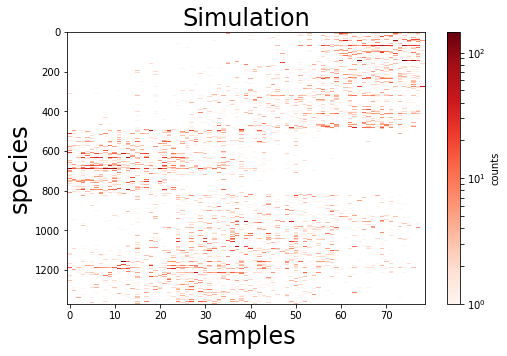

In [5]:
# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(train_table.matrix_data.todense(), 
           aspect='auto', cmap='Reds', 
           norm=colors.LogNorm()
          )
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

# Model

This is where we will specify the model.  Specifically

$e_{ij} \sim N(0, \kappa_j)$

$v_{ij} = \gamma_j + g_{i.} \cdot \beta_{.j} + e_{ij}$

$\eta_i = \Psi v_i + \theta_i$

$Y_i \sim Poisson( \exp(\eta_i) )$

$\gamma$ represents the intercept terms and $\beta$ represent the regression coefficient terms.

G and Y are both observed.  Since we are estimating both $B$ and $\theta$, we will need set priors for both of these variables.  We will set unit normal priors on both of these variables

In [6]:
# Mini batch size
epoch = y_data.shape[0] // batch_size
num_iter = int(num_epoch * epoch * batch_size)

config = tf.ConfigProto(intra_op_parallelism_threads=2, 
                        inter_op_parallelism_threads=2,
                        device_count={'CPU': 4}) 
session = tf.InteractiveSession(config=config)

In [7]:
from edward.models import Normal, Multinomial

# Place holder variables to accept input data                                                                 
G_ph = tf.placeholder(tf.float32, [batch_size, p], name='G_ph')
Y_ph = tf.placeholder(tf.float32, [batch_size, D], name='Y_ph')
total_count = tf.placeholder(tf.float32, [batch_size], name='total_count')

# Define PointMass Variables first
qgamma = tf.Variable(tf.random_normal([1, D-1]), name='qgamma')
qbeta = tf.Variable(tf.random_normal([p, D-1]), name='qB')

# Distributions
# species bias
gamma = Normal(loc=tf.zeros([1, D-1]) + gamma_mean,
               scale=tf.ones([1, D-1]) * gamma_scale, 
               name='gamma')
# regression coefficents distribution
beta = Normal(loc=tf.zeros([p, D-1]) + beta_mean,
              scale=tf.ones([p, D-1]) * beta_scale, 
              name='B')

Bprime = tf.concat([qgamma, qbeta], axis=0)

# add bias terms for samples
Gprime = tf.concat([tf.ones([batch_size, 1]), G_ph], axis=1)

# Convert basis to SparseTensor
psi = tf.SparseTensor(
    indices=np.mat([basis.row, basis.col]).transpose(),
    values=basis.data,
    dense_shape=basis.shape) 

eta = tf.matmul(Gprime, Bprime)
eta_prime = tf.transpose(
    tf.sparse_tensor_dense_matmul(psi, tf.transpose(eta))
)
phi = tf.nn.log_softmax(eta_prime)
Y = Multinomial(total_count=total_count, logits=phi, name='Y') 

loss = -(tf.reduce_sum(gamma.log_prob(qgamma)) + \
         tf.reduce_sum(beta.log_prob(qbeta)) + \
         tf.reduce_sum(Y.log_prob(Y_ph)) * (N / batch_size))

optimizer = tf.train.AdamOptimizer(learning_rate)
#global_step = tf.Variable(0, name="global_step")    

gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 10.0)
train = optimizer.apply_gradients(zip(gradients, variables))

tf.summary.scalar('loss', loss)
tf.summary.histogram('qbeta', qbeta)
tf.summary.histogram('qgamma', qgamma)
#tf.summary.histogram('gradients', gradients)
merged = tf.summary.merge_all()

tf.global_variables_initializer().run()
writer = tf.summary.FileWriter(save_path, session.graph)

losses = np.array([0.] * num_iter)
idx = np.arange(y_data.shape[0])
for i in tqdm(range(num_iter)):
    batch_idx = np.random.choice(idx, size=batch_size)
    feed_dict={
        Y_ph: y_data[batch_idx].astype(np.float32), 
        G_ph: train_metadata.values[batch_idx].astype(np.float32),
        total_count: y_data[batch_idx].sum(axis=1).astype(np.float32)
    }    
    
    if i % 100 == 99:
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        _, summary, train_loss, grads = session.run(
            [train, merged, loss, gradients],
            feed_dict=feed_dict,
            options=run_options,
            run_metadata=run_metadata
        )    
        writer.add_run_metadata(run_metadata, 'step%d' % i)    
        writer.add_summary(summary, i)
    else:
        _, summary, train_loss, grads = session.run(
            [train, merged, loss, gradients],
            feed_dict=feed_dict
        )    
        writer.add_summary(summary, i)
        
    losses[i] = train_loss
    #print("Step %d / %d: lr = %5.2f loss = %6.2f\r" %
    #      (i, num_iter, lr, train_loss))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


100%|██████████| 750/750 [00:01<00:00, 408.07it/s]


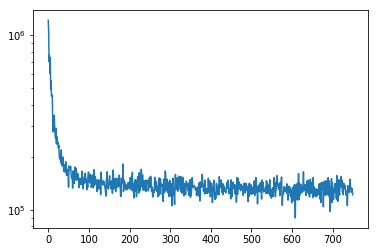

In [8]:
plt.plot(losses)
plt.yscale('log')

In [9]:
beta_ = qbeta.eval()
gamma_ = qgamma.eval()

In [10]:
def cross_validation(md, beta, gamma, data):
    """ Computes two cross validation metrics

    1) Rank difference
    2) Mean squared error on observed entries

    Parameters
    ----------
    md : np.array
       Design matrix
    beta : np.array
       Regression coefficients
    gamma : np.array
       Regression intercepts
    data : np.array
       Dense matrix of counts.  Samples are rows
       and features are columns.

    Returns
    -------
    mse : float
       Mean squared error across all of the cells in the matrix
    mrc : float
       Mean rank correlation.  This take the average spearman
       correlation across every sample.  This boils down to matching
       rank species curves per sample.
    """
    n = data.sum(axis=1).reshape(-1, 1)
    pred = np.multiply(n, clr_inv(md @ beta + gamma))
    mse = np.mean(np.ravel(data - pred)**2)
    mrc = np.mean([
        spearmanr(data[i, :], pred[i, :])[0]
        for i in range(data.shape[0])
    ])
    return mse, mrc

In [11]:
from scipy.spatial.distance import cityblock

def cross_validation(md, beta, gamma, data, k=10):
    """ Computes two cross validation metrics

    1) Rank difference
    2) Mean squared error on observed entries

    Parameters
    ----------
    md : np.array
       Design matrix
    beta : np.array
       Regression coefficients
    gamma : np.array
       Regression intercepts
    data : np.array
       Dense matrix of counts.  Samples are rows
       and features are columns.
    k : int
       Top k ranks to compare

    Returns
    -------
    mse : float
       Mean squared error across all of the cells in the matrix
    mrc : float
       Mean rank correlation.  This take the average spearman
       correlation across every sample.  This boils down to matching
       rank species curves per sample.
    """
    n = data.sum(axis=1).reshape(-1, 1)
    pred = np.multiply(n, clr_inv(md @ beta + gamma))
    mse = np.mean([cityblock(data[i], pred[i]) for i in range(data.shape[0])]) / data.shape[1]
    
    rc = []
    for i in range(data.shape[0]):
        idx = np.argsort(data[i, :])[-k:]
        r = spearmanr(data[i, idx], pred[i, idx])
        rc.append(r.correlation)
    mrc = np.mean(rc)
    return mse, mrc

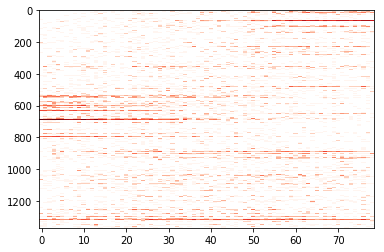

In [12]:
from skbio.stats.composition import clr_inv
from numpy.random import multinomial
n = y_data.sum(axis=1)
p = clr_inv((G_data @ beta_ + gamma_) @ basis.T)
counts = np.vstack([multinomial(n[i], p[i]) for i in range(p.shape[0])]).T
plt.imshow(counts, aspect='auto', cmap='Reds', 
           norm=colors.LogNorm())

In [13]:
y_test = np.array(test_table.matrix_data.todense()).T
mse, mrc = cross_validation(test_metadata.values, beta_ @ basis.T, gamma_ @ basis.T, y_test) 

In [14]:
mse, mrc

(0.7990725155683258, 0.14953790866280955)

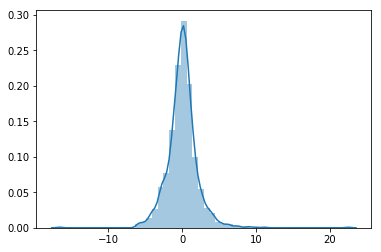

In [15]:
sns.distplot(gamma_)

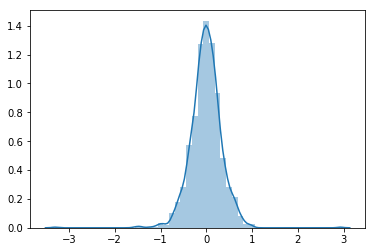

In [16]:
sns.distplot(beta_)